In [19]:
import os
import sys 

current_directory = os.getcwd()
models_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(models_directory)

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import pandas as pd
import seaborn as sns
import itertools

import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import LogLocator, LogFormatter
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps
from vecopsciml.operators import zero_order as zo
from vecopsciml.algebra import zero_order as azo

# Imports de las funciones creadas para este programa
from utils.folders import create_folder
from utils.load_data import load_data
from utils.checkpoints import load_results
from utils.fourier_base import compute_fourier_base

from vecopsciml.operators.zero_order import Mx, My

In [21]:
from architectures.pgnniv_baseline import PGNNIVBaseline
from architectures.pgnniv_fourier import PGNNIVFourier
from architectures.pgnniv_pod import PGNNIVPOD
from architectures.pgnniv_decoder import PGNNIVAutoencoder
from architectures.autoencoder import Autoencoder

In [22]:
data_name = 'non_linear_10_0'

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'

dataset = load_data(DATA_PATH)
dx = dataset['x_step_size']
dy = dataset['y_step_size']

def relative_error(validation, prediction, dx=dx, dy=dy):
    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) / np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))
    return prediction_error

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_10_0/non_linear_10_0.pkl


In [23]:
def smooth_curve(data, window_size=1000):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = np.max(lst)
    return [x / max_value for x in lst]

linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

# plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

In [24]:
DEVICE = torch.device("cpu")

Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_0/non_linear_1000_0.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_0/non_linear_1000_0.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_0/non_linear_1000_0.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_1/non_linear_1000_1.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_1/non_linear_1000_1.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_linear_1000_1/non_linear_1000_1.pkl
Data successfully loaded from: /home/rmunoz/Escritorio/rmunozTMELab/Physically-Guided-Machine-Learning/data/non_

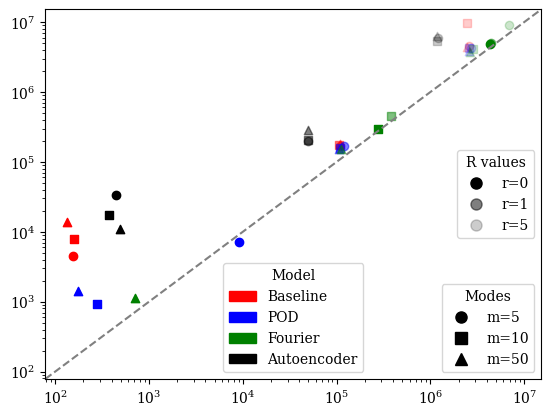

In [27]:
N = [1000] 
R = [0, 1, 5]
n_modes = [5, 10, 50]
models = ['baseline', 'POD', 'fourier','autoencoder']
# models = ['POD']

# Estilos
model_styles = {
    'baseline': {'color': 'red', 'title': 'Baseline'},
    'POD': {'color': 'blue', 'title': 'POD'},
    'fourier': {'color': 'green', 'title': 'Fourier'},
    'autoencoder': {'color': 'black', 'title': 'Autoencoder'}
}

mode_markers = {
    5: 'o',    # círculo
    10: 's',   # cuadrado
    50: '^'    # triángulo
}

def get_alpha(r):
    
    if r == 0:
        alpha = 1
    elif r == 1:
        alpha = 0.5
    elif r == 5:
        alpha = 0.2
    return alpha

plotted_points = []

plt.figure()

for model_i in models:
    for n_i in N:
        for r_i in R:
            for mode_i in n_modes:

                idx = (n_i, model_i, mode_i)
                
                data_name = f'non_linear_{n_i}_{r_i}'
                model_name = f'{model_i}_model_{mode_i}'
                
                ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), "../"))
                DATA_PATH = os.path.join(ROOT_PATH, r'data/', data_name, data_name) + '.pkl'
                RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results/', data_name)


                MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name)

                dataset = load_data(DATA_PATH)

                # Train data splitting in train/test
                X = torch.tensor(dataset['X_train'], dtype=torch.float32).unsqueeze(1)
                y = torch.tensor(dataset['y_train'], dtype=torch.float32).unsqueeze(1)
                K = torch.tensor(dataset['k_train'], dtype=torch.float32).unsqueeze(1)
                f = torch.tensor(dataset['f_train'], dtype=torch.float32).unsqueeze(1)

                X_train, X_test, y_train, y_test, K_train, K_test, f_train, f_test = train_test_split(X, y, K, f, test_size=0.3, random_state=42)

                # Data processing and adequacy with our TensOps library
                X_train = X_train.to(DEVICE)
                X_test = X_test.to(DEVICE)

                y_train = TensOps(y_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                y_test = TensOps(y_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                K_train = TensOps(K_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                K_test = TensOps(K_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                f_train = TensOps(f_train.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)
                f_test = TensOps(f_test.to(DEVICE).requires_grad_(True), space_dimension=2, contravariance=0, covariance=0)

                # Loading and processing validation data
                X_val = torch.tensor(dataset['X_val'], dtype=torch.float32).unsqueeze(1)
                y_val = TensOps(torch.tensor(dataset['y_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                K_val = TensOps(torch.tensor(dataset['k_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)
                f_val = TensOps(torch.tensor(dataset['f_val'], dtype=torch.float32, requires_grad=True).unsqueeze(1), space_dimension=2, contravariance=0, covariance=0)

                # Predictive network architecture
                input_shape = X_train[0].shape
                predictive_layers = [20, 10, mode_i, 10, 20]
                predictive_output = y_train.values[0].shape

                # Explanatory network architecture
                explanatory_input = Mx(My(y_train)).values[0].shape
                explanatory_layers = [10]
                explanatory_output = Mx(My(f_train)).values[0].shape

                # Other parameters
                n_filters_explanatory = 5

                if model_i == 'baseline':

                    try:
                        model = PGNNIVBaseline(input_shape, predictive_layers, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        train_total_loss_list = lists['train_total_loss_list']
                        test_total_loss_list = lists['test_total_loss_list']

                    except:
                        pass

                elif model_i == 'POD':
                    try:
                        if X_train.shape[0] < mode_i:
                            continue

                        U_train, S_train, Vt_train = torch.linalg.svd(y_train.values.detach().squeeze().to('cpu').view(y_train.values.detach().shape[0], -1), full_matrices=False)
                        U_reduced_train = U_train[:, :mode_i]
                        S_reduced_train = S_train[:mode_i]
                        Vt_reduced_train = Vt_train[:mode_i, :]
                        POD_base = Vt_reduced_train.to(DEVICE)

                        model = PGNNIVPOD(input_shape, predictive_layers, POD_base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        with open(os.path.join(MODEL_RESULTS_PATH, "time.txt"), "r") as f:
                            time_pod = float(f.read().strip())  # Usa float o int según lo que necesites

                        time = np.cumsum(lists['time_list'])[-1] + time_pod

                        train_total_loss_list = lists['train_total_loss_list']
                        test_total_loss_list = lists['test_total_loss_list']

                    except:
                        pass

                elif model_i == 'fourier':
                    try:

                        X_mesh = torch.tensor(dataset['X_mesh'])
                        Y_mesh = torch.tensor(dataset['Y_mesh'])

                        base = compute_fourier_base(mode_i, X_mesh, Y_mesh)

                        model = PGNNIVFourier(input_shape, predictive_layers, base, predictive_output, explanatory_input, explanatory_layers, explanatory_output, n_filters_explanatory, device=DEVICE).to(DEVICE)
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PATH, map_location=DEVICE)

                        time = np.cumsum(lists['time_list'])[-1]

                        train_total_loss_list = lists['train_total_loss_list']
                        test_total_loss_list = lists['test_total_loss_list']
                    
                    except:
                        pass

                elif model_i == 'autoencoder':
                    try:
                        MODEL_RESULTS_AE_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_AE'
                        MODEL_RESULTS_PGNNIV_PATH = os.path.join(ROOT_PATH, r'results/', data_name, model_name) + '_NN'

                        autoencoder_input_shape = y_train.values[0].shape
                        latent_space_dim = [20, 10, mode_i, 10, 20]
                        autoencoder_output_shape = y_train.values[0].shape

                        autoencoder = Autoencoder(autoencoder_input_shape, latent_space_dim, autoencoder_output_shape).to(DEVICE)
                        optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4)

                        autoencoder, lists = load_results(autoencoder, optimizer, MODEL_RESULTS_AE_PATH, map_location=torch.device('cpu'))

                        hyperparameters_ae = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)

                        time_ae = np.cumsum(lists['time_list'])[-1]

                        pretrained_encoder = autoencoder.encoder
                        pretrained_decoder = autoencoder.decoder

                        for param in pretrained_decoder.parameters():
                            param.requires_grad = False

                        pgnniv_model = PGNNIVAutoencoder(input_shape, predictive_layers, pretrained_decoder, predictive_output, explanatory_input,
                                                        explanatory_layers, explanatory_output, n_filters_explanatory).to(DEVICE)
                        optimizer = torch.optim.Adam(pgnniv_model.parameters(), lr=1e-4)

                        model, lists = load_results(pgnniv_model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=torch.device('cpu'))
                        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
                        model, lists = load_results(model, optimizer, MODEL_RESULTS_PGNNIV_PATH, map_location=DEVICE)

                        time = time_ae + np.cumsum(lists['time_list'])[-1]

                        train_total_loss_list = lists['train_total_loss_list']
                        test_total_loss_list = lists['test_total_loss_list']

                    except:
                        pass

                
                color = model_styles[model_i]['color']
                marker = mode_markers[mode_i]
                alpha = get_alpha(r_i)

                plt.scatter(
                    train_total_loss_list[-1],
                    test_total_loss_list[-1],
                    color=color,
                    alpha=alpha,
                    marker=marker,
                    label=f'N={n_i}, r={r_i}, m={mode_i}'
                )
                plt.xscale('log')
                plt.yscale('log')
                # plt.xlim([1e1, 1e6])
                # ax1.set_ylim([1e1, 1e10])
lims = [
    min(plt.gca().get_xlim()[0], plt.gca().get_ylim()[0]),
    max(plt.gca().get_xlim()[1], plt.gca().get_ylim()[1]),
]
plt.plot(lims, lims, '--', color='gray')
plt.xlim(lims)
plt.ylim(lims)

# Leyenda estratificada

# Leyenda para modelos (color)
model_patches = [mpatches.Patch(color=info['color'], label=info['title']) for info in model_styles.values()]

# Leyenda para modos (marker)
mode_lines = [mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=8, label=f'm={mode}') for mode, marker in mode_markers.items()]

# Leyenda para r (alpha), con un marker fijo para que se note transparencia
r_alphas = [mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, alpha=get_alpha(r), label=f'r={r}') for r in R]

# Añadimos las leyendas por separado, ubicándolas donde prefieras
# Ejemplo: modelos a la derecha, modos arriba, r abajo

first_legend = plt.legend(handles=model_patches, title='Model', loc='lower center')
plt.gca().add_artist(first_legend)

second_legend = plt.legend(handles=mode_lines, title='Modes', loc='lower right')
plt.gca().add_artist(second_legend)

third_legend = plt.legend(handles=r_alphas, title='R values', loc='center right')

plt.show()